# Applied Machine Learning - Assignment - 2.

### Classifying a GPU Run Time as high time consuming or low time consuming process.

#### As part of this project, we will use SVM with different kernel functions, Decision Tree and XGBoost for classification.

### Importing required libraries.

In [1]:
##
## First, we will import all the necessary libraries that we will need in the code.
##
import pandas                   as pd
import numpy                    as np
import matplotlib               as mpl
import matplotlib.pyplot        as plt
import seaborn                  as sb
from   sklearn                  import preprocessing 
from   sklearn.model_selection  import train_test_split
from   sklearn                  import svm
from   sklearn.metrics          import classification_report, confusion_matrix
import itertools
from   sklearn.tree             import DecisionTreeClassifier
from   sklearn                  import metrics
import xgboost                  as xgb
from   sklearn.model_selection  import KFold
from   sklearn.model_selection  import cross_val_score
from   sklearn.model_selection  import cross_val_predict
from   sklearn.metrics          import confusion_matrix
from   sklearn.metrics          import accuracy_score 
from   sklearn.metrics          import classification_report
from   sklearn                  import tree
import graphviz 
from   sklearn.model_selection  import learning_curve

%matplotlib inline

#### We will now import the metadata to the working environment for performing EDA and Visual Analysis to have a greater depth of understanding of the data and find out meaningful insights.

In [2]:
##
## Provide the directory where metadata file is stored and read the file from that library. Displaying the initial few rows.
##
csv_path = 'D:/Second Semester - MSBA - UTD/Applied Machine Learning/Assignment 1/sgemm_product.csv'
gpu_df = pd.read_csv(csv_path)
gpu_df.head() # Displays the first 5 rows.

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [3]:
##
## Now, let's add a column to the last which will have the average of the 4 runs. Let's name it AvgRun.
##
gpu_df.rename(columns={"Run1 (ms)":"Run1", "Run2 (ms)":"Run2", "Run3 (ms)":"Run3","Run4 (ms)":"Run4"}, inplace = True)

gpu_df["AvgRun"] = gpu_df[["Run1","Run2","Run3","Run4"]].mean(numeric_only=True, axis=1)
gpu_df.head()
#gpu_df.set_index('AvgRun',inplace=True)

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1,Run2,Run3,Run4,AvgRun
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81,118.6625


In [4]:
##
## Now let's check the statistical summary of the dataframe
##
gpu_df[gpu_df.isnull().any(axis=1)].count()

gpu_df.dtypes
gpu_df.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1,Run2,Run3,Run4,AvgRun
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669,217.571953
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413,368.750161
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000,13.317500
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000,40.667500
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000,69.790000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000,228.387500
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000,3341.507500


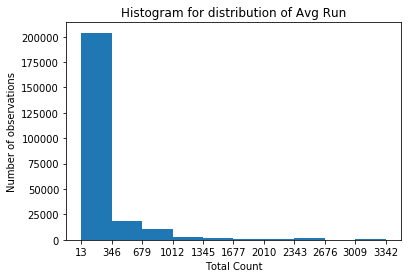

In [5]:
##
## Histogram for distribution of MWG
##
count, bin_edges = np.histogram(gpu_df["AvgRun"])
gpu_df['AvgRun'].plot(kind="hist",xticks=bin_edges)
plt.title("Histogram for distribution of Avg Run")
plt.ylabel("Number of observations")
plt.xlabel("Total Count")
plt.show()

#### Normalizing the dataset.

In [6]:
names = gpu_df.columns

scale = preprocessing.StandardScaler()

gpu_norm_df = scale.fit_transform(gpu_df)
gpu_norm_df = pd.DataFrame(gpu_norm_df, columns=names)

gpu_norm_df.head(6)

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1,Run2,Run3,Run4,AvgRun
0,-1.516757,-1.516757,-1.210997,-0.753894,-0.753894,-0.998054,-0.998054,-1.0,-0.741449,-0.741449,-1.0,-1.0,-1.0,-1.0,-0.277465,-0.275877,-0.268497,-0.275927,-0.274446
1,-1.516757,-1.516757,-1.210997,-0.753894,-0.753894,-0.998054,-0.998054,-1.0,-0.741449,-0.741449,-1.0,-1.0,-1.0,1.0,-0.378085,-0.377918,-0.375101,-0.375228,-0.376589
2,-1.516757,-1.516757,-1.210997,-0.753894,-0.753894,-0.998054,-0.998054,-1.0,-0.741449,-0.741449,-1.0,-1.0,1.0,-1.0,-0.373451,-0.371300,-0.371005,-0.370400,-0.371545
3,-1.516757,-1.516757,-1.210997,-0.753894,-0.753894,-0.998054,-0.998054,-1.0,-0.741449,-0.741449,-1.0,-1.0,1.0,1.0,-0.361311,-0.346319,-0.354757,-0.357895,-0.355077
4,-1.516757,-1.516757,-1.210997,-0.753894,-0.753894,-0.998054,-0.998054,-1.0,-0.741449,-0.741449,-1.0,1.0,-1.0,-1.0,-0.277817,-0.259305,-0.257159,-0.278612,-0.268229
5,-1.516757,-1.516757,-1.210997,-0.753894,-0.753894,-0.998054,-0.998054,-1.0,-0.741449,-0.741449,-1.0,1.0,-1.0,1.0,-0.370037,-0.366634,-0.354052,-0.367226,-0.364494


#### Calculating the median value of the AvgRun feature.

In [7]:
median_run = gpu_norm_df['AvgRun'].median()
median_run

-0.40076527321510147

#### Creating the run type class in the dataset. If the average run time of the record is less than Median value, it is given class 0 (low run type) and if greater or equal, it is termed as 1(high run type)

In [8]:
gpu_norm_df['Runtype'] = [0 if x < median_run else 1 for x in gpu_norm_df['AvgRun']]
gpu_norm_df.head()

x_gpu_norm = gpu_norm_df[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']]
y_gpu_norm = gpu_norm_df[['Runtype']]
y_gpu_norm.head()

,Runtype
0,1
1,1
2,1
3,1
4,1


### Heat Map plot.

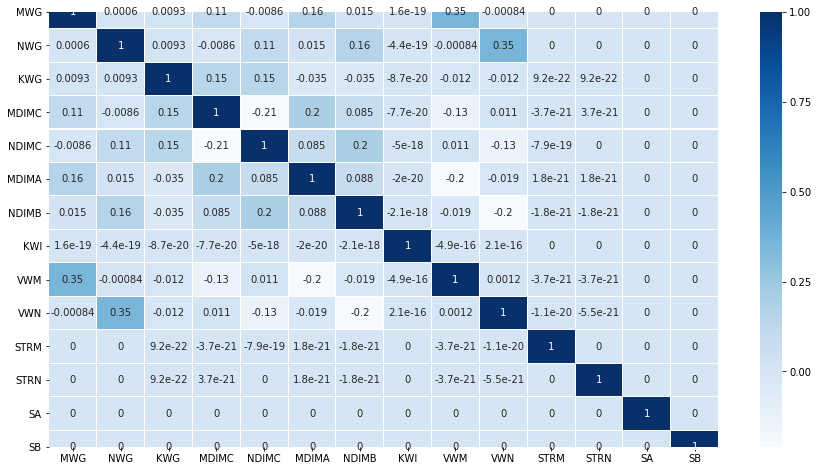

In [9]:
corr=x_gpu_norm.corr()
plt.figure(figsize=(15,8))
sb.heatmap(corr,annot=True,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Blues")
plt.show()

#### Data Partitioning for model building and evaluation process.

In [10]:
x_train_gpu, x_test_gpu, y_train_gpu, y_test_gpu = train_test_split(x_gpu_norm, y_gpu_norm,test_size=0.3, random_state=16)

In [11]:
x_train = np.asarray(x_train_gpu)
y_train = np.asarray(y_train_gpu)

x_test  = np.asarray(x_test_gpu)
y_test  = np.asarray(y_test_gpu)

### Implementing the SVM Algorithm.

In [51]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(x_train, y_train)

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [52]:
yhat_svm_lin = svm_model.predict(x_test)

In [53]:
yhat_svm_lin[0:5]

array([0, 1, 0, 1, 1], dtype=int64)

In [13]:
svm_model_p = svm.SVC(kernel='poly')
svm_model_p.fit(x_train, y_train)

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [55]:
yhat_svm_pol = svm_model_p.predict(x_test)

In [17]:
svm_model_r = svm.SVC(kernel='rbf')
svm_model_r.fit(x_train, y_train)

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [57]:
yhat_svm_rbf = svm_model_r.predict(x_test)

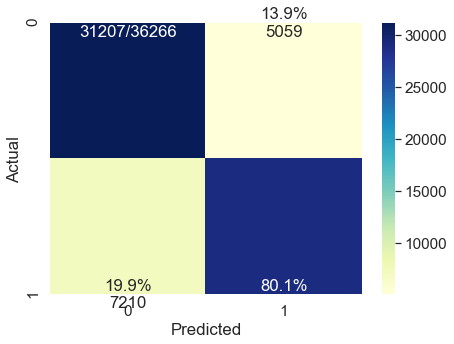

In [100]:
plot_cm(y_test, yhat_svm_lin)

In [157]:
print('Report SVM Linear Kernel')
print(classification_report(y_test, yhat_svm_lin))

Report SVM Linear Kernel
              precision    recall  f1-score   support

           0       0.81      0.86      0.84     36266
           1       0.85      0.80      0.83     36214

    accuracy                           0.83     72480
   macro avg       0.83      0.83      0.83     72480
weighted avg       0.83      0.83      0.83     72480



In [15]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = svm_model,
X = x_train,
y = y_train, 
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for SVM - Linear Kernel.', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.15,0.2)

NameError: name 'svm_model' is not defined

In [61]:
print("SVM Accuracy Poly: ", metrics.accuracy_score(y_test, yhat_svm_pol))

SVM Accuracy Poly:  0.9071054083885209


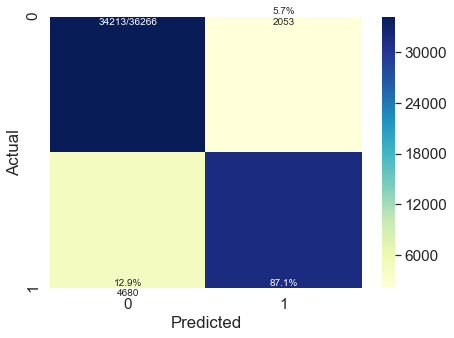

In [160]:
plot_cm(y_test, yhat_svm_pol)

In [159]:
print('Report GPU Poly Kernel SVM')
print(classification_report(y_test, yhat_svm_pol))

Report GPU Poly Kernel SVM
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     36266
           1       0.94      0.87      0.90     36214

    accuracy                           0.91     72480
   macro avg       0.91      0.91      0.91     72480
weighted avg       0.91      0.91      0.91     72480



C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: Dat

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(0, 1)

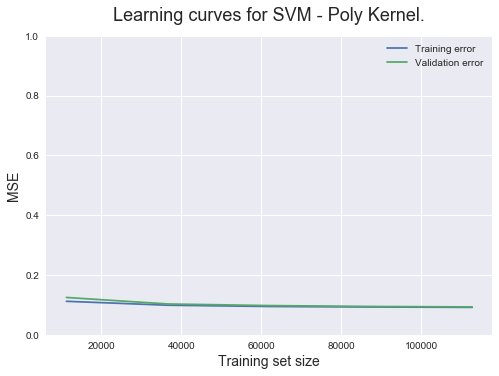

In [16]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = svm_model_p,
X = x_train,
y = y_train, 
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for SVM - Poly Kernel.', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)

In [62]:
print("SVM Accuracy rbf: ", metrics.accuracy_score(y_test, yhat_svm_rbf))

SVM Accuracy rbf:  0.9599061810154526


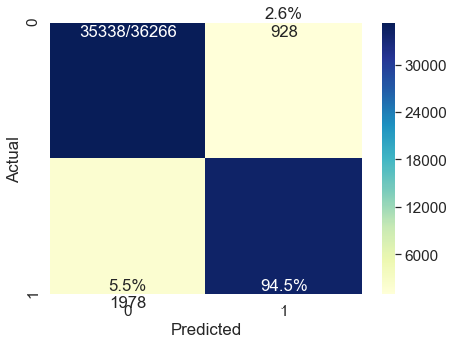

In [102]:
plot_cm(y_test, yhat_svm_rbf)

In [158]:
print('Report SVM RBF Kernel')
print(classification_report(y_test, yhat_svm_rbf))

Report SVM RBF Kernel
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     36266
           1       0.97      0.95      0.96     36214

    accuracy                           0.96     72480
   macro avg       0.96      0.96      0.96     72480
weighted avg       0.96      0.96      0.96     72480



C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: Dat

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(0, 1)

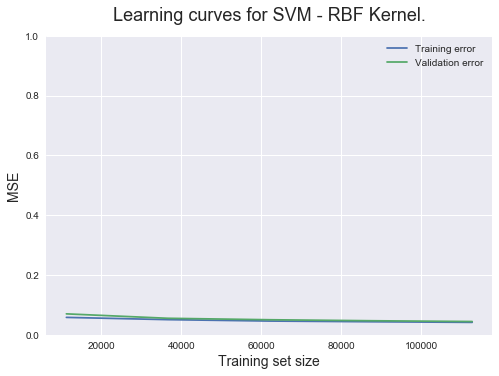

In [18]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = svm_model_r,
X = x_train,
y = y_train, 
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for SVM - RBF Kernel.', fontsize = 18, y = 1.03)
plt.legend() 
plt.ylim(0,1)

In [223]:
svm_l_acc = metrics.accuracy_score(y_test, yhat_svm_lin)
svm_l_rec = metrics.recall_score(y_test, yhat_svm_lin)
svm_l_prs = metrics.precision_score(y_test, yhat_svm_lin)
svm_l =[svm_l_acc,svm_l_rec,svm_l_prs]

In [224]:
svm_r_acc = metrics.accuracy_score(y_test, yhat_svm_rbf)
svm_r_rec = metrics.recall_score(y_test, yhat_svm_rbf)
svm_r_prs = metrics.precision_score(y_test, yhat_svm_rbf)
svm_r =[svm_r_acc,svm_r_rec,svm_r_prs]

In [225]:
svm_p_acc = metrics.accuracy_score(y_test, yhat_svm_pol)
svm_p_rec = metrics.recall_score(y_test, yhat_svm_pol)
svm_p_prs = metrics.precision_score(y_test, yhat_svm_pol)
svm_p =[svm_p_acc,svm_p_rec,svm_p_prs]

### Implement the Decision Treee Algorithm 

In [161]:
gpuTree = DecisionTreeClassifier(criterion="gini")
gpuTree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [162]:
gpuTree_fit = gpuTree.fit(x_train, y_train)

In [163]:
yhat_tree_pred = gpuTree.predict(x_test)

In [164]:
yhat_tree_pred[0:5]

array([0, 1, 1, 1, 1], dtype=int64)

In [165]:
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_test, yhat_tree_pred))

Decision Trees's Accuracy:  0.9911975717439293


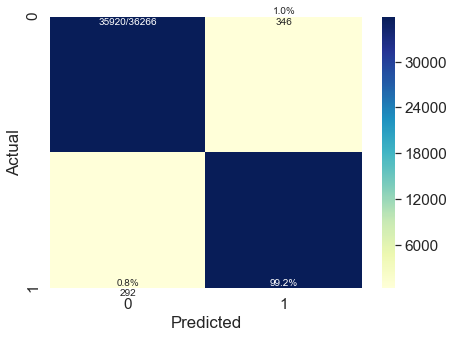

In [166]:
plot_cm(y_test, yhat_tree_pred)

In [167]:
print('Report - GPU - Tree Max Depth')
print(classification_report(y_test, yhat_tree_pred))

Report - GPU - Tree Max Depth
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     36266
           1       0.99      0.99      0.99     36214

    accuracy                           0.99     72480
   macro avg       0.99      0.99      0.99     72480
weighted avg       0.99      0.99      0.99     72480



C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


(-0.01, 0.05)

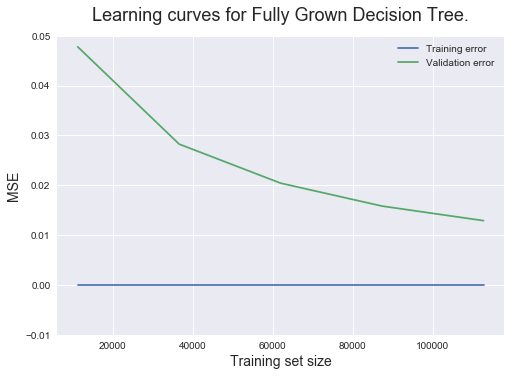

In [246]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = DecisionTreeClassifier(criterion="gini"),
X = x_train,
y = y_train, 
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Fully Grown Decision Tree.', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(-0.01,0.05)

In [168]:
gpuTree_1 = DecisionTreeClassifier(criterion="gini", max_depth=10)
gpuTree_1

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [169]:
gpuTree_1.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [170]:
yhat_tree_pred_1 = gpuTree_1.predict(x_test)

In [171]:
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_test, yhat_tree_pred_1))

Decision Trees's Accuracy:  0.9547737306843267


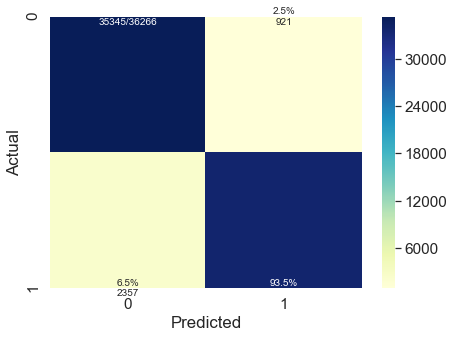

In [172]:
plot_cm(y_test, yhat_tree_pred_1)

In [174]:
print('Report - GPU - Tree Depth 10')
print(classification_report(y_test, yhat_tree_pred_1))

Report - GPU - Tree Depth 10
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     36266
           1       0.97      0.93      0.95     36214

    accuracy                           0.95     72480
   macro avg       0.96      0.95      0.95     72480
weighted avg       0.96      0.95      0.95     72480



In [175]:
gpuTree_2 = DecisionTreeClassifier(criterion="gini", max_depth=20)
gpuTree_2

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [176]:
gt_tree_fit = gpuTree_2.fit(x_train, y_train)

In [177]:
yhat_tree_pred_2 = gpuTree_2.predict(x_test)

In [178]:
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_test, yhat_tree_pred_2))

Decision Trees's Accuracy:  0.9911837748344371


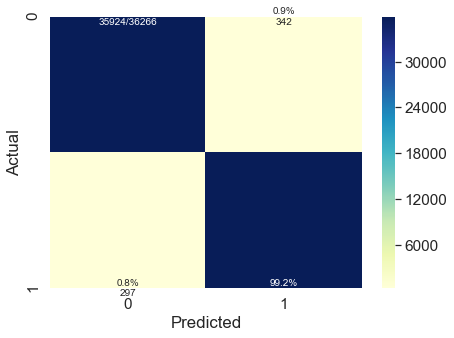

In [179]:
plot_cm(y_test, yhat_tree_pred_2)

In [180]:
print('Report Tree GPU Depth 20')
print(classification_report(y_test, yhat_tree_pred_2))

Report Tree GPU Depth 20
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     36266
           1       0.99      0.99      0.99     36214

    accuracy                           0.99     72480
   macro avg       0.99      0.99      0.99     72480
weighted avg       0.99      0.99      0.99     72480



In [219]:
dtr_p_acc = metrics.accuracy_score(y_test, yhat_tree_pred)
dtr_p_rec = metrics.recall_score(y_test, yhat_tree_pred)
dtr_p_prs = metrics.precision_score(y_test, yhat_tree_pred)
dtr_p=[dtr_p_acc,dtr_p_rec,dtr_p_prs]

In [220]:
dtr_p_acc_1 = metrics.accuracy_score(y_test, yhat_tree_pred_1)
dtr_p_rec_1 = metrics.recall_score(y_test, yhat_tree_pred_1)
dtr_p_prs_1 = metrics.precision_score(y_test, yhat_tree_pred_1)
dtr_p_1=[dtr_p_acc_1,dtr_p_rec_1,dtr_p_prs_1]

In [221]:
dtr_p_acc_2 = metrics.accuracy_score(y_test, yhat_tree_pred_2)
dtr_p_rec_2 = metrics.recall_score(y_test, yhat_tree_pred_2)
dtr_p_prs_2 = metrics.precision_score(y_test, yhat_tree_pred_2)
dtr_p_2=[dtr_p_acc_2,dtr_p_rec_2,dtr_p_prs_2]

### Implementing the XGBoost algorithm

In [181]:
gpu_xgb = xgb.XGBClassifier(max_depth=10)

In [182]:
gpu_xgb.fit(x_train, y_train)

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [183]:
yhat_xgb = gpu_xgb.predict(x_test)

In [184]:
print("XGBoost Trees's Accuracy: ", metrics.accuracy_score(y_test, yhat_xgb))

XGBoost Trees's Accuracy:  0.9939983443708609


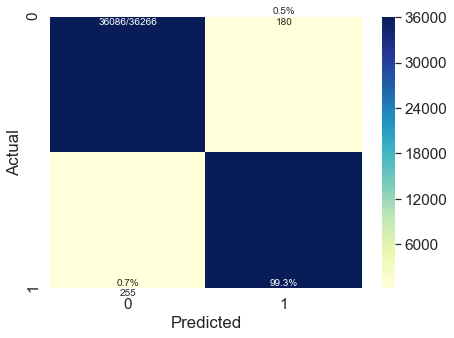

In [185]:
plot_cm(y_test, yhat_xgb)

In [195]:
print('Report GPU XGBoost - Depth 10.')
print(classification_report(y_test, yhat_xgb))

Report GPU XGBoost - Depth 10.
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     36266
           1       1.00      0.99      0.99     36214

    accuracy                           0.99     72480
   macro avg       0.99      0.99      0.99     72480
weighted avg       0.99      0.99      0.99     72480



In [187]:
gpu_xgb_2 = xgb.XGBClassifier(max_depth=5)

In [188]:
gpu_xgb_2.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [189]:
yhat_xgb_2 = gpu_xgb_2.predict(x_test)

In [190]:
print("XGBoost Trees's Accuracy: ", metrics.accuracy_score(y_test, yhat_xgb_2))

XGBoost Trees's Accuracy:  0.9781870860927152


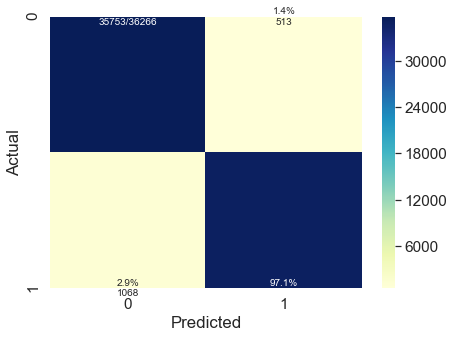

In [191]:
plot_cm(y_test, yhat_xgb_2)

In [194]:
print('Report GPU XGBoost - Depth 5')
print(classification_report(y_test, yhat_xgb_2))

Report GPU XGBoost - Depth 5
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     36266
           1       0.99      0.97      0.98     36214

    accuracy                           0.98     72480
   macro avg       0.98      0.98      0.98     72480
weighted avg       0.98      0.98      0.98     72480



C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vect

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0, 0.04)

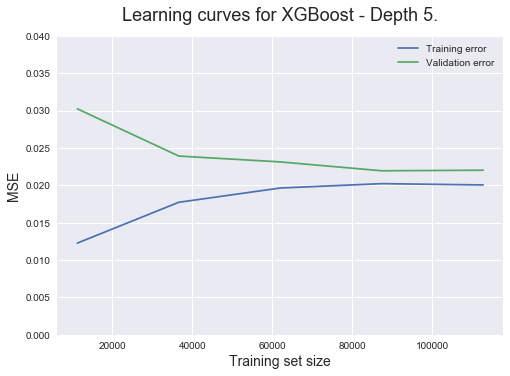

In [249]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = xgb.XGBClassifier(max_depth=5),
X = x_train,
y = y_train, 
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for XGBoost - Depth 5.', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,0.04)

In [217]:
xgb_p_acc = metrics.accuracy_score(y_test, yhat_xgb)
xgb_p_rec = metrics.recall_score(y_test, yhat_xgb)
xgb_p_prs = metrics.precision_score(y_test, yhat_xgb)
xgb_p = [xgb_p_acc,xgb_p_rec,xgb_p_prs]

In [218]:
xgb_p_acc_2 = metrics.accuracy_score(y_test, yhat_xgb_2)
xgb_p_rec_2 = metrics.recall_score(y_test, yhat_xgb_2)
xgb_p_prs_2 = metrics.precision_score(y_test, yhat_xgb_2)
xgb_p_2 = [xgb_p_acc_2,xgb_p_rec_2,xgb_p_prs_2]

### Implementing k-fold cross-validation with all algorithms.

#### Cross validation with SVM.

In [64]:
svm_cv_scores_l = cross_val_score(svm_model, x_test, y_test, cv=6)
svm_cv_scores_l

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-v

array([0.82575946, 0.82700108, 0.83807947, 0.83402318, 0.82664128,
       0.83177415])

In [65]:
svm_cv_scores_p = cross_val_score(svm_model_p, x_test, y_test, cv=6)
svm_cv_scores_p

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193:

array([0.89818724, 0.89942886, 0.90496689, 0.90206954, 0.90255816,
       0.90007451])

In [66]:
svm_cv_scores_r = cross_val_score(svm_model_r, x_test, y_test, cv=6)
svm_cv_scores_r

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193:

array([0.95016969, 0.94967304, 0.95264901, 0.94975166, 0.94825731,
       0.95223114])

In [67]:
svm_cv_scores_s = cross_val_score(svm_model_s, x_test, y_test, cv=6)
svm_cv_scores_s

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193:

array([0.66790829, 0.66484563, 0.66688742, 0.67086093, 0.65800149,
       0.66437619])

### Cross Validation - Decision Trees

In [70]:
tree_cv_scores = cross_val_score(gpuTree, x_test, y_test, cv=6)
tree_cv_scores

array([0.97922357, 0.98071352, 0.98087748, 0.97996689, 0.97880619,
       0.98203494])

In [79]:
tree_cv_scores_1 = cross_val_score(gpuTree_1, x_test, y_test, cv=6)
tree_cv_scores_1

array([0.94983859, 0.95356345, 0.95057947, 0.95372517, 0.95305903,
       0.95471479])

In [80]:
tree_cv_scores_2 = cross_val_score(gpuTree_2, x_test, y_test, cv=6)
tree_cv_scores_2

array([0.88924758, 0.89123417, 0.8910596 , 0.89188742, 0.89295471,
       0.8930375 ])

### Cross Validation - XGBoost

In [85]:
xgb_cv_scores = cross_val_score(gpu_xgb, x_test, y_test, cv=6)
xgb_cv_scores

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.98187236, 0.98394173, 0.98501656, 0.98253311, 0.98236609,
       0.98418743])

In [196]:
xgb_cv_scores_10 = cross_val_score(gpu_xgb_2, x_test, y_test, cv=6)
xgb_cv_scores_10

C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sarth\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.97640924, 0.97731976, 0.97930464, 0.97533113, 0.97607418,
       0.97756437])

#### Cross validation summary

In [197]:
columns = ["CV1", "CV2", "CV3", "CV4","CV5","CV6"]
rows = ["SVM-LIN", "SVM-RBF", "SVM-POLY","D-TREE Full","D-TREE D-10","D-TREE D-20","XGB D-5","XGB D-10"]
data = np.array([svm_cv_scores_l,svm_cv_scores_r,svm_cv_scores_p,tree_cv_scores,tree_cv_scores_1,tree_cv_scores_2, xgb_cv_scores,xgb_cv_scores_10])
df = pd.DataFrame(data=data, index=rows, columns=columns)
df

,CV1,CV2,CV3,CV4,CV5,CV6
SVM-LIN,0.825759,0.827001,0.838079,0.834023,0.826641,0.831774
SVM-RBF,0.950170,0.949673,0.952649,0.949752,0.948257,0.952231
SVM-POLY,0.898187,0.899429,0.904967,0.902070,0.902558,0.900075
D-TREE Full,0.979224,0.980714,0.980877,0.979967,0.978806,0.982035
D-TREE D-10,0.949839,0.953563,0.950579,0.953725,0.953059,0.954715
D-TREE D-20,0.889248,0.891234,0.891060,0.891887,0.892955,0.893038
XGB D-5,0.981872,0.983942,0.985017,0.982533,0.982366,0.984187
XGB D-10,0.976409,0.977320,0.979305,0.975331,0.976074,0.977564


### Confusion Matrix Function.

In [99]:
def plot_cm(y_true, y_pred, figsize=(7,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sb.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

### Comparision of Performance of all Algorithms.

In [228]:
columns = ["Accuracy", "Precision", "Recall"]
rows = ["SVM-LIN", "SVM-RBF", "SVM-POLY","D-TREE Full","D-TREE D-10","D-TREE D-20","XGB D-5","XGB D-10"]
data = np.array([svm_l,svm_r,svm_p,dtr_p,dtr_p_1,dtr_p_2,xgb_p, xgb_p_2])
df1 = pd.DataFrame(data=data, index=rows, columns=columns)
df1

,Accuracy,Precision,Recall
SVM-LIN,0.830726,0.800906,0.851481
SVM-RBF,0.959906,0.945380,0.973609
SVM-POLY,0.907105,0.870768,0.938875
D-TREE Full,0.991198,0.991937,0.990460
D-TREE D-10,0.954774,0.934915,0.973518
D-TREE D-20,0.991184,0.991799,0.990568
XGB D-5,0.993998,0.992959,0.995019
XGB D-10,0.978187,0.970509,0.985614
